In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from scipy.stats import zscore
import psycopg2
import os
import plotly.express as px
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
os.chdir('..')

In [3]:
from db.connection import DatabaseConnection
from db.sql_preprocessor import DBFilter
from src.utils import missing_values_table, find_agg, convert_bytes_to_megabytes, fix_outlier, remove_outliers
from src.plot_utils import set_seaborn_style, plot_histogram_kde, plot_boxplot, plot_time_series, plot_countplot

In [4]:
db_connection = DatabaseConnection()
set_seaborn_style()

In [5]:
db_connection.connect()

Connected to the database.


In [6]:
query = "SELECT * FROM xdr_data"
df = db_connection.execute_query(query)

In [7]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [8]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [9]:
duplicates = df.duplicated()
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [10]:
# Check for missing values in the original DataFrame df
missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.
Missing Values in df:
                                          Missing Values  % of Total Values  \
Nb of sec with 37500B < Vol UL                    130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B            111843               74.6   
Nb of sec with 125000B < Vol DL                    97538               65.0   
TCP UL Retrans. Vol (Bytes)                        96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B           93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B              92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B             88317               58.9   
TCP DL Retrans. Vol (Bytes)                        88146               58.8   
HTTP UL (Bytes)                                    81810               54.5   
HTTP DL (Bytes)                                    81474               54.3   
Avg RTT DL (ms)       

In [11]:
# Example usage of find_agg on df
agg_result = find_agg(df, agg_column='MSISDN/Number', agg_metric='sum', col_name='Total_DL_Sum', top=5, order=False)

# Create a new DataFrame with the aggregated values
new_df = pd.DataFrame(agg_result)

# Print the new DataFrame
print("New DataFrame with Aggregated Values:")
print(new_df)


New DataFrame with Aggregated Values:
        MSISDN/Number  Total_DL_Sum
106855   8.823971e+14  8.823971e+14
106854   3.370000e+14  3.370000e+14
106853   3.197021e+12  3.197021e+12
13526    3.362632e+10  6.052738e+11
13180    3.362578e+10  5.716382e+11


In [12]:
# XDR analysis

In [13]:
# Using mean values for null fields

In [14]:
db_filter = DBFilter(df)

In [15]:
filtered_numeric_df = db_filter.filter_numeric_columns(threshold=50)

In [16]:
columns_to_exclude = ['Bearer Id', 'Start', 'End', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']
for column in filtered_numeric_df.columns:
    if column not in columns_to_exclude:
        filtered_numeric_df[column].fillna(filtered_numeric_df[column].mean(), inplace=True)

In [17]:
filtered_numeric_df.head()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,770.000000,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,213.056424,176.837163,21660.940053,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,235.000000,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.000000,176.837163,21660.940053,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,524.751521,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,213.056424,176.837163,21660.940053,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,486.000000,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,213.056424,176.837163,21660.940053,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,565.000000,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,213.056424,176.837163,21660.940053,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [18]:
missing_values = filtered_numeric_df.isnull().sum()
print(missing_values)

Bearer Id                                    991
Start ms                                       0
End ms                                         0
Dur. (ms)                                      0
IMSI                                         570
MSISDN/Number                               1066
IMEI                                         572
Avg RTT DL (ms)                                0
Avg RTT UL (ms)                                0
Avg Bearer TP DL (kbps)                        0
Avg Bearer TP UL (kbps)                        0
TCP DL Retrans. Vol (Bytes)                    0
TCP UL Retrans. Vol (Bytes)                    0
DL TP < 50 Kbps (%)                            0
50 Kbps < DL TP < 250 Kbps (%)                 0
250 Kbps < DL TP < 1 Mbps (%)                  0
DL TP > 1 Mbps (%)                             0
UL TP < 10 Kbps (%)                            0
10 Kbps < UL TP < 50 Kbps (%)                  0
50 Kbps < UL TP < 300 Kbps (%)                 0
UL TP > 300 Kbps (%)

In [19]:
# # Handle outliers using z-score for specific columns
# columns_to_exclude = ['Bearer Id', 'Start', 'End', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Handset Manufacturer', 'Handset Type']
# for column in filtered_numeric_df.columns:
#     if column not in columns_to_exclude:
#         z_scores = zscore(filtered_numeric_df[column])
#         filtered_numeric_df[column + '_Outlier'] = (np.abs(z_scores) > 3).astype(int)
#         filtered_numeric_df = filtered_numeric_df[filtered_numeric_df[column + '_Outlier'] == 0]  # Remove rows with outliers

In [20]:
user_xdr_sessions = filtered_numeric_df.groupby(['MSISDN/Number'])['Bearer Id'].count().reset_index(name='Number_of_xDR_sessions')

In [21]:
user_xdr_sessions.head()

,MSISDN/Number,Number_of_xDR_sessions
0,3.360100e+10,1
1,3.360100e+10,1
2,3.360100e+10,1
3,3.360101e+10,1
4,3.360101e+10,1


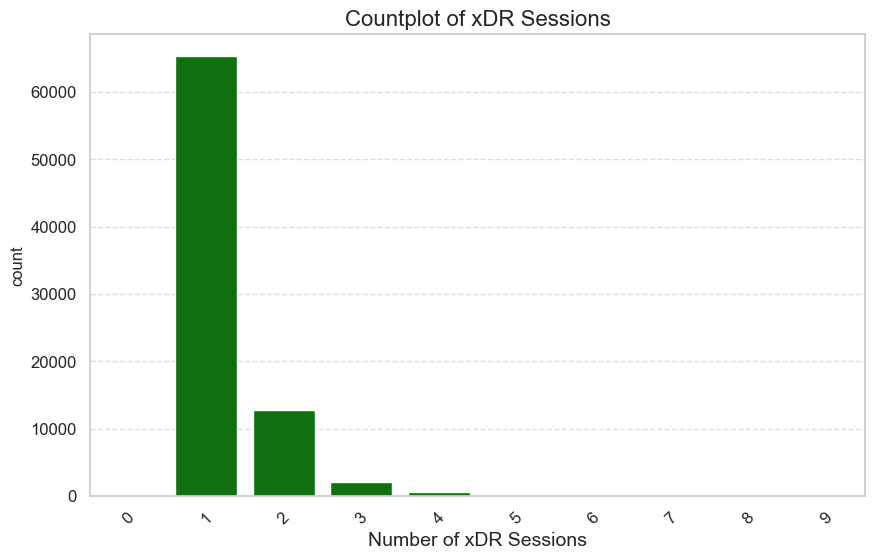

In [22]:
# Plot countplot for xDR sessions (example assuming categorical variable)
plot_countplot(
    data=user_xdr_sessions,
    x_column='Number_of_xDR_sessions',
    title='Countplot of xDR Sessions',
    x_label='Number of xDR Sessions',
    color = 'green'
)

In [23]:
user_session_duration = filtered_numeric_df.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Total_Session_Duration_ms')

In [24]:
user_session_duration['Total_Session_Duration_sec'] = user_session_duration['Total_Session_Duration_ms'] / 1000

In [25]:
user_session_duration.head()

,MSISDN/Number,Total_Session_Duration_ms,Total_Session_Duration_sec
0,3.360100e+10,116720.0,116.720
1,3.360100e+10,181230.0,181.230
2,3.360100e+10,134969.0,134.969
3,3.360101e+10,49878.0,49.878
4,3.360101e+10,18549.0,18.549


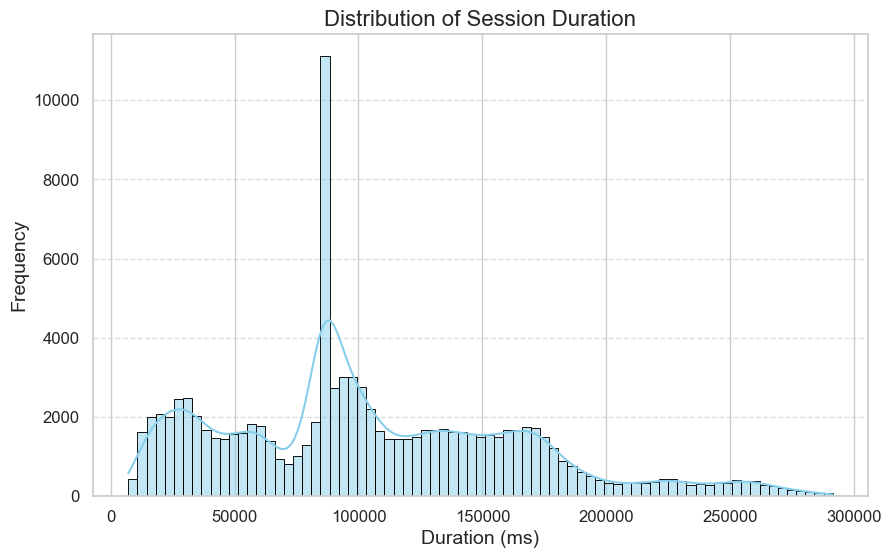

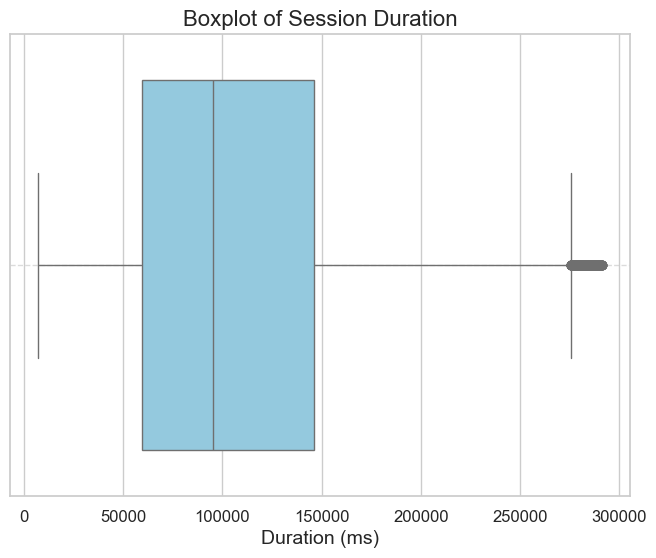

In [26]:
plot_histogram_kde(
    data=filtered_numeric_df['Dur. (ms)'],
    title='Distribution of Session Duration',
    x_label='Duration (ms)',
    y_label='Frequency',
    color='skyblue'
)

# Plot boxplot
plot_boxplot(
    data=filtered_numeric_df['Dur. (ms)'],
    title='Boxplot of Session Duration',
    x_label='Duration (ms)',
    color='skyblue'
)

In [27]:
filtered_numeric_df_out = remove_outliers(filtered_numeric_df, 'Dur. (ms)', z_threshold=2.7)

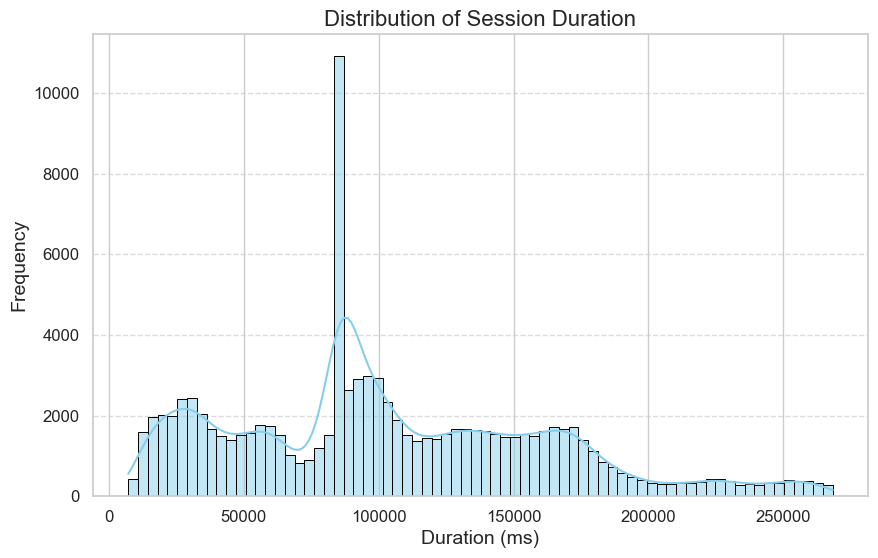

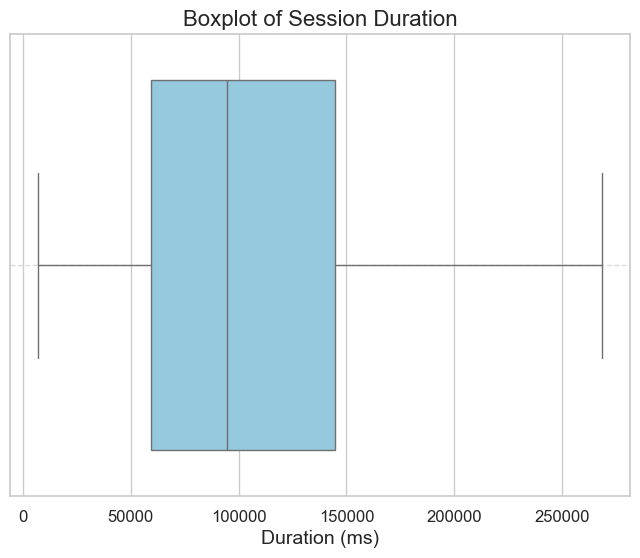

In [28]:
plot_histogram_kde(
    data=filtered_numeric_df_out['Dur. (ms)'],
    title='Distribution of Session Duration',
    x_label='Duration (ms)',
    y_label='Frequency',
    color='skyblue'
)

# Plot boxplot
plot_boxplot(
    data=filtered_numeric_df_out['Dur. (ms)'],
    title='Boxplot of Session Duration',
    x_label='Duration (ms)',
    color='skyblue'
)

In [29]:
user_data_usage = filtered_numeric_df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()


In [30]:
user_data_usage.head()

,MSISDN/Number,Total DL (Bytes),Total UL (Bytes)
0,3.360100e+10,842637466.0,36053108.0
1,3.360100e+10,120755184.0,36104459.0
2,3.360100e+10,556659663.0,39306820.0
3,3.360101e+10,401993172.0,20327526.0
4,3.360101e+10,547096937.0,38481427.0


In [31]:
user_data_usage['Total DL (MB)'] = convert_bytes_to_megabytes(user_data_usage, 'Total DL (Bytes)')
user_data_usage['Total UL (MB)'] = convert_bytes_to_megabytes(user_data_usage, 'Total UL (Bytes)')

In [32]:
user_data_usage.head()

,MSISDN/Number,Total DL (Bytes),Total UL (Bytes),Total DL (MB),Total UL (MB)
0,3.360100e+10,842.637466,36.053108,842.637466,36.053108
1,3.360100e+10,120.755184,36.104459,120.755184,36.104459
2,3.360100e+10,556.659663,39.306820,556.659663,39.306820
3,3.360101e+10,401.993172,20.327526,401.993172,20.327526
4,3.360101e+10,547.096937,38.481427,547.096937,38.481427


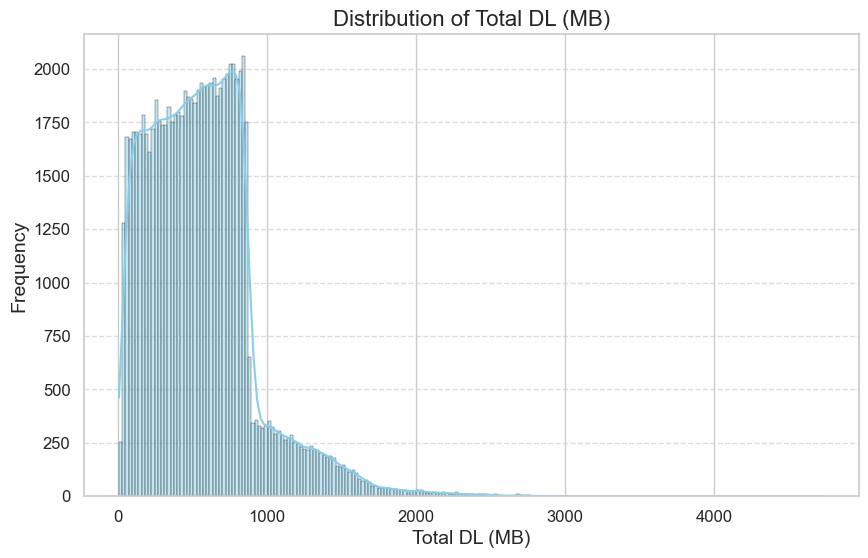

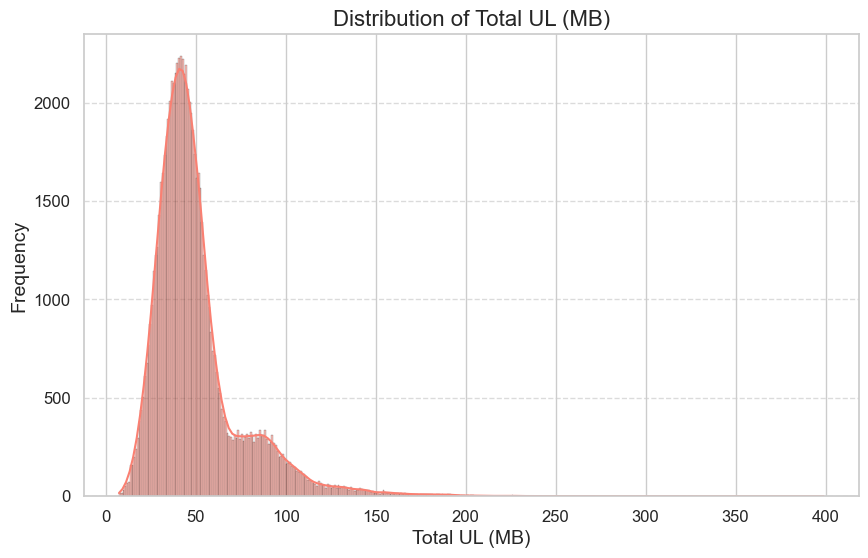

In [33]:
# Plot histogram with KDE for 'Total DL (MB)'
plot_histogram_kde(
    data=user_data_usage['Total DL (MB)'],
    title='Distribution of Total DL (MB)',
    x_label='Total DL (MB)',
    y_label='Frequency',
    color='skyblue'
)

# Plot histogram with KDE for 'Total UL (MB)'
plot_histogram_kde(
    data=user_data_usage['Total UL (MB)'],
    title='Distribution of Total UL (MB)',
    x_label='Total UL (MB)',
    y_label='Frequency',
    color='salmon'
)


In [34]:
user_app_data_usage = filtered_numeric_df.groupby(['MSISDN/Number', 'Bearer Id'])[
    ['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)']
].sum().reset_index()

In [35]:
user_app_data_usage.head()

,MSISDN/Number,Bearer Id,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
0,3.360100e+10,1.311448e+19,2206504.0,25631.0,3337123.0,1051882.0,837400.0,493962.0,14900201.0,6724347.0,10265105.0,16915876.0,811091133.0,1367528.0,377096990.0,9473882.0
1,3.360100e+10,7.349883e+18,2598548.0,62017.0,4197697.0,1137166.0,2828821.0,478960.0,5324251.0,7107972.0,770569.0,10451194.0,105035298.0,14714780.0,279557701.0,2152370.0
2,3.360100e+10,7.349883e+18,3148004.0,47619.0,3343483.0,99643.0,2436500.0,768880.0,2137272.0,19196298.0,16525919.0,2827981.0,529068485.0,9759228.0,495086501.0,6607171.0
3,3.360101e+10,1.304243e+19,251469.0,28825.0,5937765.0,3740728.0,2178618.0,106052.0,4393123.0,2584198.0,1157362.0,784730.0,388074835.0,3051292.0,25248001.0,10031701.0
4,3.360101e+10,7.349883e+18,1359904.0,28581.0,6309062.0,2019919.0,979859.0,911925.0,8027633.0,13012887.0,21177155.0,6051459.0,509243324.0,2989307.0,705348475.0,13467349.0


In [36]:
# Select columns for conversion
columns_to_convert = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

for column in columns_to_convert:
    new_column_name = column.replace(' Bytes', ' GB')  # Update column name
    user_app_data_usage[new_column_name] = convert_bytes_to_megabytes(user_app_data_usage, column)  # Convert to gigabytes

# Display the modified DataFrame
user_app_data_usage.head()


,MSISDN/Number,Bearer Id,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
0,3.360100e+10,1.311448e+19,2.206504,0.025631,3.337123,1.051882,0.837400,0.493962,14.900201,6.724347,10.265105,16.915876,811.091133,1.367528,377.096990,9.473882
1,3.360100e+10,7.349883e+18,2.598548,0.062017,4.197697,1.137166,2.828821,0.478960,5.324251,7.107972,0.770569,10.451194,105.035298,14.714780,279.557701,2.152370
2,3.360100e+10,7.349883e+18,3.148004,0.047619,3.343483,0.099643,2.436500,0.768880,2.137272,19.196298,16.525919,2.827981,529.068485,9.759228,495.086501,6.607171
3,3.360101e+10,1.304243e+19,0.251469,0.028825,5.937765,3.740728,2.178618,0.106052,4.393123,2.584198,1.157362,0.784730,388.074835,3.051292,25.248001,10.031701
4,3.360101e+10,7.349883e+18,1.359904,0.028581,6.309062,2.019919,0.979859,0.911925,8.027633,13.012887,21.177155,6.051459,509.243324,2.989307,705.348475,13.467349


In [37]:
print(user_app_data_usage.columns)


Index(['MSISDN/Number', 'Bearer Id', 'Social Media DL (Bytes)',
       'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
       'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)',
       'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
       'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)',
       'Other UL (Bytes)'],
      dtype='object')


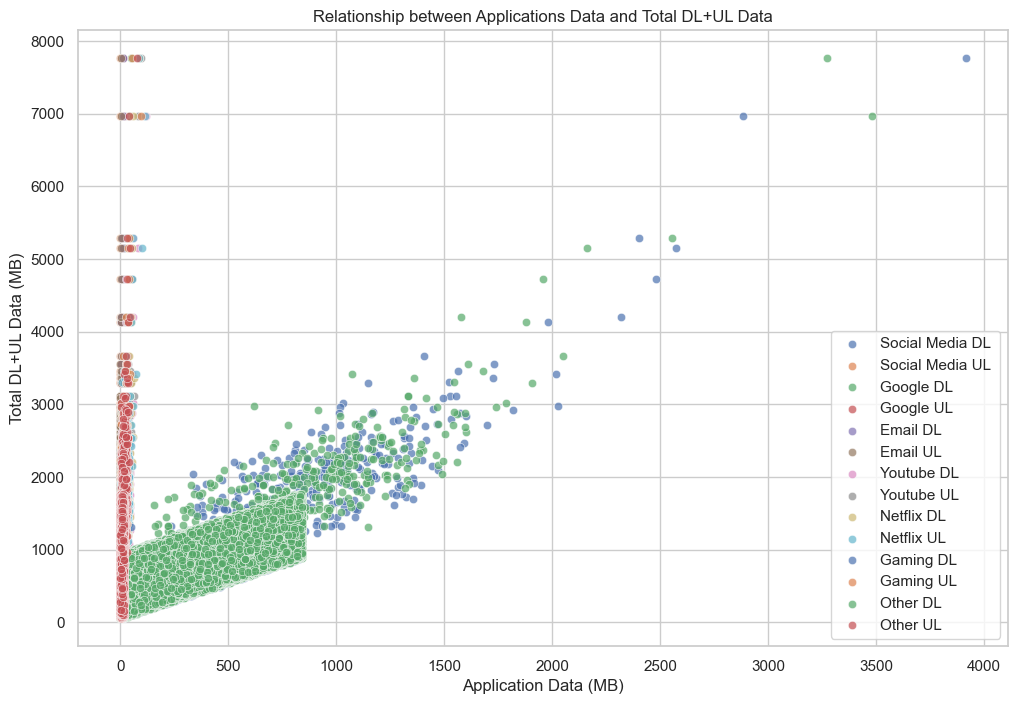

In [38]:
user_app_data_usage['Total DL+UL (Bytes)'] = user_app_data_usage.iloc[:, 2:].sum(axis=1)

# List of columns for bivariate analysis
columns_for_analysis = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

# Create scatter plot for each application on the same graph
plt.figure(figsize=(12, 8))

for app in columns_for_analysis:
    # Scatter plot for each application
    sns.scatterplot(x=user_app_data_usage[app], y=user_app_data_usage['Total DL+UL (Bytes)'], label=app.replace('(Bytes)', '').replace('(Bytes)', ''), alpha=0.7)

plt.title('Relationship between Applications Data and Total DL+UL Data')
plt.xlabel('Application Data (MB)')
plt.ylabel('Total DL+UL Data (MB)')
plt.legend()
plt.show()


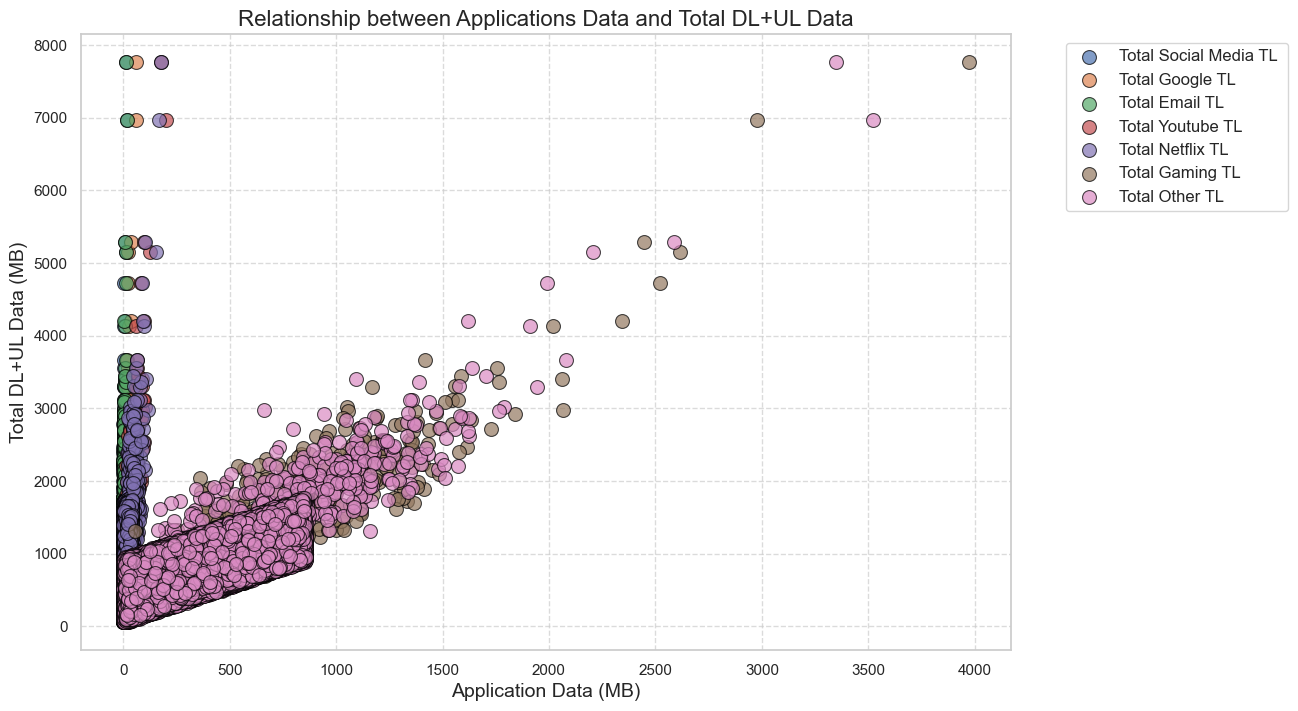

In [39]:
# List of columns for bivariate analysis
columns_for_analysis = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Calculate total DL+UL data for each application
for app in columns_for_analysis:
    user_app_data_usage[f'Total {app} TL (Bytes)'] = user_app_data_usage[f'{app} DL (Bytes)'] + user_app_data_usage[f'{app} UL (Bytes)']

# Set Seaborn style
sns.set(style='whitegrid')

# Create scatter plot for each application on the same graph
plt.figure(figsize=(12, 8))

# List of columns for bivariate analysis
columns_for_combined_analysis = [f'Total {app} TL (Bytes)' for app in columns_for_analysis]

for app in columns_for_combined_analysis:
    # Scatter plot for each application
    sns.scatterplot(
        x=user_app_data_usage[app],
        y=user_app_data_usage['Total DL+UL (Bytes)'],
        label=app.replace('(Bytes)', ''),
        alpha=0.7,
        s=100,  # Increase marker size
        edgecolor='black',  # Add black edges to markers
    )

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')

# Set plot title and axis labels
plt.title('Relationship between Applications Data and Total DL+UL Data', fontsize=16)
plt.xlabel('Application Data (MB)', fontsize=14)
plt.ylabel('Total DL+UL Data (MB)', fontsize=14)

# Add grid lines with a dashed style
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

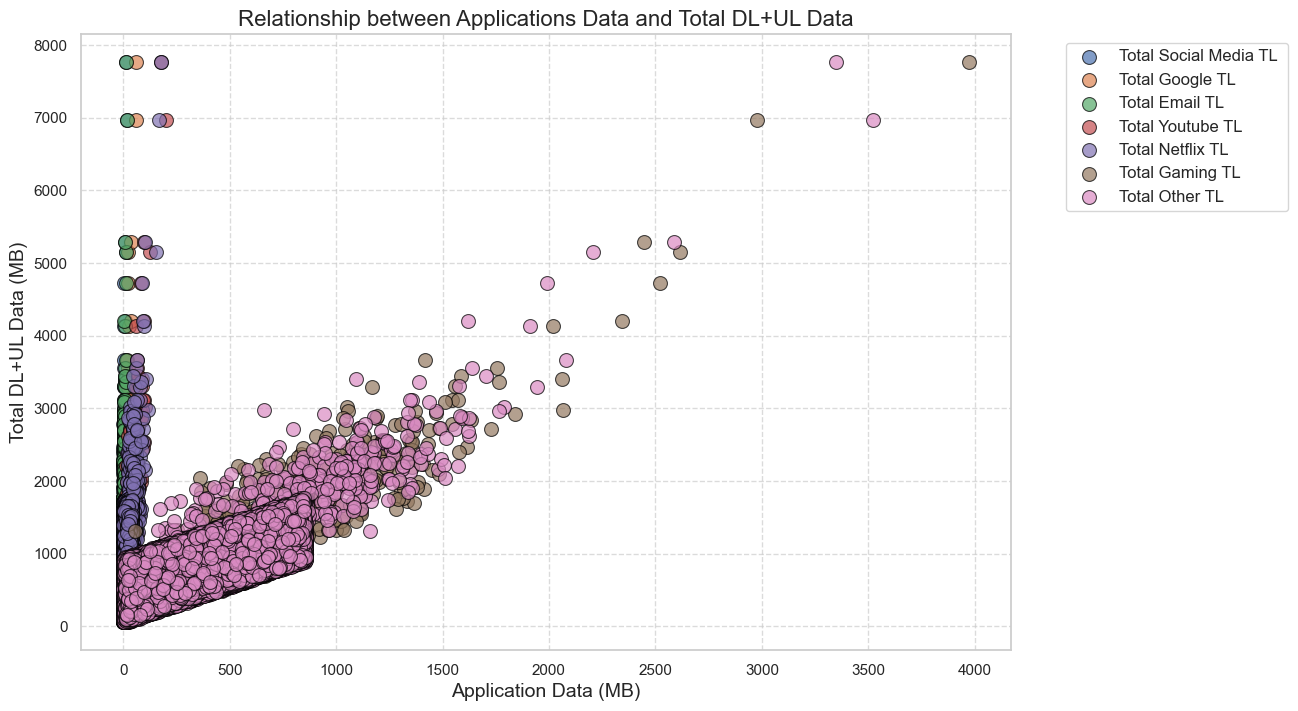

In [40]:
# List of columns for bivariate analysis
columns_for_analysis = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Calculate total DL+UL data for each application
for app in columns_for_analysis:
    user_app_data_usage[f'Total {app} TL (Bytes)'] = user_app_data_usage[f'{app} DL (Bytes)'] + user_app_data_usage[f'{app} UL (Bytes)']

# Create scatter plot for each application on the same graph
plt.figure(figsize=(12, 8))

# List of columns for bivariate analysis
columns_for_combined_analysis = [f'Total {app} TL (Bytes)' for app in columns_for_analysis]

for app in columns_for_combined_analysis:
    # Scatter plot for each application
    sns.scatterplot(
        x=user_app_data_usage[app],
        y=user_app_data_usage['Total DL+UL (Bytes)'],
        label=app.replace('(Bytes)', ''),
        alpha=0.7,
        s=100,  # Increase marker size
        edgecolor='black',  # Add black edges to markers
    )

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')

# Set plot title and axis labels
plt.title('Relationship between Applications Data and Total DL+UL Data', fontsize=16)
plt.xlabel('Application Data (MB)', fontsize=14)
plt.ylabel('Total DL+UL Data (MB)', fontsize=14)

# Add grid lines with a dashed style
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [41]:
# Calculating basic metrics for the entire dataset
basic_metrics = filtered_numeric_df.describe()

In [42]:
print("Basic Metrics:")
print(basic_metrics)

Basic Metrics:
          Bearer Id       Start ms         End ms      Dur. (ms)  \
count  1.000330e+05  100578.000000  100578.000000  100578.000000   
mean   9.983252e+18     524.773162     523.445200  105692.138346   
std    2.885835e+18     266.477126     266.396069   60237.699258   
min    6.917538e+18      51.000000      51.000000    7142.000000   
25%    7.349883e+18     301.000000     300.000000   59711.750000   
50%    7.349883e+18     524.751521     523.918927   95232.500000   
75%    1.311448e+19     748.000000     749.000000  146040.750000   
max    1.318654e+19     999.000000     999.000000  291266.000000   

               IMSI  MSISDN/Number          IMEI  Avg RTT DL (ms)  \
count  1.002440e+05   9.997700e+04  1.002440e+05    100578.000000   
mean   2.082017e+14   3.704351e+10  4.236963e+13       200.711210   
std    1.860157e+10   1.065704e+12  1.777633e+13       111.007294   
min    2.082001e+14   3.360100e+10  4.400152e+11        51.000000   
25%    2.082010e+14   3.365

In [43]:
# Additional Metrics
# median
median_values = filtered_numeric_df.median()

In [44]:
print("\nMedian Values:")
print(median_values)


Median Values:
Bearer Id                    7.349883e+18
Start ms                     5.247515e+02
End ms                       5.239189e+02
Dur. (ms)                    9.523250e+04
IMSI                         2.082015e+14
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Length: 96, dtype: float64


In [45]:
# mode
mode_values = filtered_numeric_df.mode().iloc[0]

In [46]:
print("\nMode Values:")
print(mode_values)


Mode Values:
Bearer Id                    1.304243e+19
Start ms                     5.247515e+02
End ms                       5.239189e+02
Dur. (ms)                    8.639900e+04
IMSI                         2.082010e+14
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Name: 0, Length: 96, dtype: float64


In [47]:
# standard deviation
std_dev_values = filtered_numeric_df.std()

In [48]:
print("\nStandard Deviation Values:")
print(std_dev_values)


Standard Deviation Values:
Bearer Id                    2.885835e+18
Start ms                     2.664771e+02
End ms                       2.663961e+02
Dur. (ms)                    6.023770e+04
IMSI                         1.860157e+10
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Length: 96, dtype: float64


In [49]:
# variance
variance_values = filtered_numeric_df.var()

In [50]:
print("\nVariance Values:")
print(variance_values)


Variance Values:
Bearer Id                    8.328044e+36
Start ms                     7.101006e+04
End ms                       7.096687e+04
Dur. (ms)                    3.628580e+09
IMSI                         3.460186e+20
                                 ...     
Gaming UL (Bytes)_Outlier    0.000000e+00
Other DL (Bytes)_Outlier     0.000000e+00
Other UL (Bytes)_Outlier     0.000000e+00
Total UL (Bytes)_Outlier     0.000000e+00
Total DL (Bytes)_Outlier     0.000000e+00
Length: 96, dtype: float64


In [51]:
# Dispersion Parameters for Each Quantitative Variable
dispersion_params = filtered_numeric_df.describe().transpose()

# Additional Dispersion Parameters (if needed)
dispersion_params['range'] = filtered_numeric_df.max() - filtered_numeric_df.min()
dispersion_params['iqr'] = filtered_numeric_df.quantile(0.75) - filtered_numeric_df.quantile(0.25)

# Print Results
print("Dispersion Parameters for Each Quantitative Variable:")
print(dispersion_params[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'iqr']])


Dispersion Parameters for Each Quantitative Variable:
                                   mean           std           min  \
Bearer Id                  9.983252e+18  2.885835e+18  6.917538e+18   
Start ms                   5.247732e+02  2.664771e+02  5.100000e+01   
End ms                     5.234452e+02  2.663961e+02  5.100000e+01   
Dur. (ms)                  1.056921e+05  6.023770e+04  7.142000e+03   
IMSI                       2.082017e+14  1.860157e+10  2.082001e+14   
...                                 ...           ...           ...   
Gaming UL (Bytes)_Outlier  0.000000e+00  0.000000e+00  0.000000e+00   
Other DL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   
Other UL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   
Total UL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   
Total DL (Bytes)_Outlier   0.000000e+00  0.000000e+00  0.000000e+00   

                                    25%           50%           75%  \
Bearer Id             

In [54]:
# Calculate total duration per user
user_total_duration = user_session_duration.groupby('MSISDN/Number')['Total_Session_Duration_sec'].sum().reset_index(name='Total_Duration')

# Calculate deciles based on total duration
user_total_duration['Decile'] = pd.qcut(user_total_duration['Total_Duration'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], labels=False, duplicates='drop')

# Merge with user data usage to get 'Total DL+UL (Bytes)' for each user
user_data_usage_decile = pd.merge(user_total_duration, user_data_usage, on='MSISDN/Number')

# Calculate total data (DL+UL) per decile class
total_data_per_decile = user_data_usage_decile.groupby('Decile')['Total DL+UL (Bytes)'].sum().reset_index(name='Total_Data_Per_Decile')

# Print the result
print(total_data_per_decile)

NameError: name 'user_data_duration_combined' is not defined

In [55]:
# Calculate deciles based on total duration
user_data_duration_combined['Decile'] = pd.qcut(user_data_duration_combined['Total_Session_Duration_ms'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False)

# Filter only the top five decile classes
top_five_deciles_data = user_data_duration_combined[user_data_duration_combined['Decile'].isin([6, 7, 8, 9, 10])]

# Display the result for the top five deciles
print(top_five_deciles_data)

# Group by decile and compute the total data per decile class for the top five deciles
decile_data_summary_top_five = top_five_deciles_data.groupby('Decile')['Total DL+UL (MB)'].sum().reset_index()

# Display the result for the top five deciles
print(decile_data_summary_top_five)


NameError: name 'user_data_duration_combined' is not defined

In [56]:
# Plot histogram with KDE for 'Total DL+UL (MB)' across deciles
plot_histogram_kde(
    data=user_data_duration_combined['Total DL+UL (MB)'],
    title='Distribution of Total DL+UL Across Deciles',
    x_label='Total DL+UL (MB)',
    y_label='Frequency',
    color='skyblue'
)

NameError: name 'user_data_duration_combined' is not defined

In [57]:
# Select the relevant columns for correlation analysis
selected_columns = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

# Create a subset DataFrame with the selected columns
correlation_data = user_app_data_usage[selected_columns]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

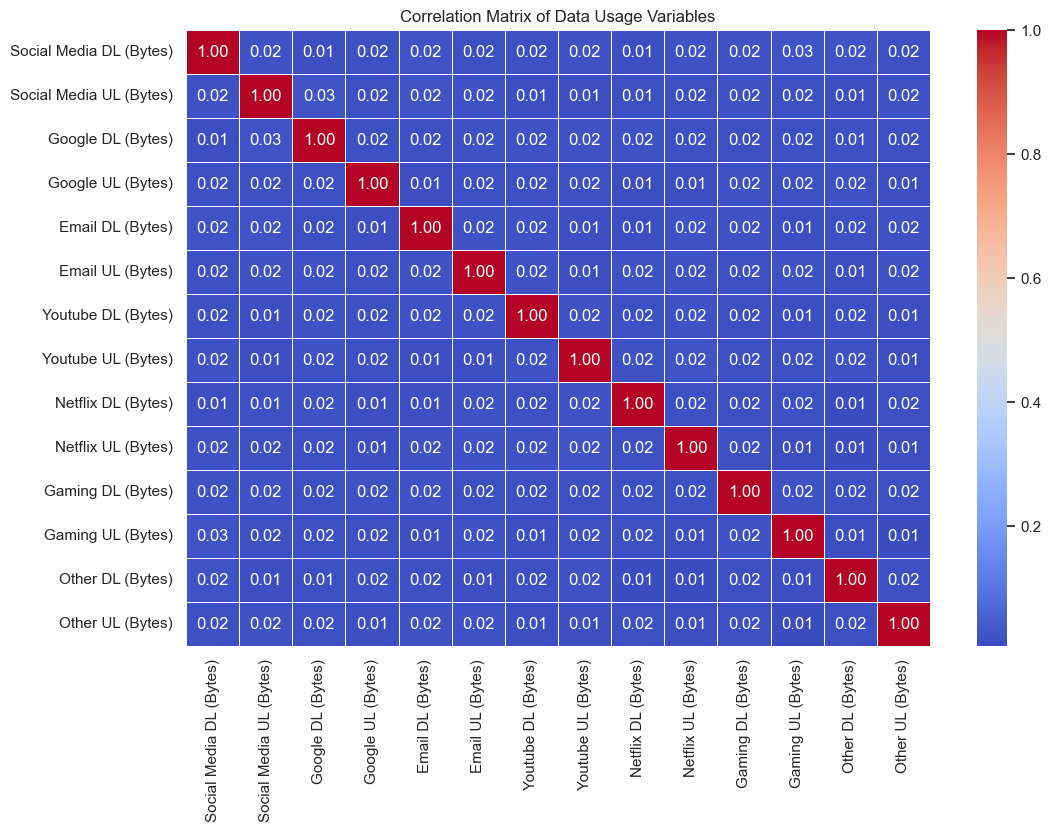

In [58]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Data Usage Variables')
plt.show()

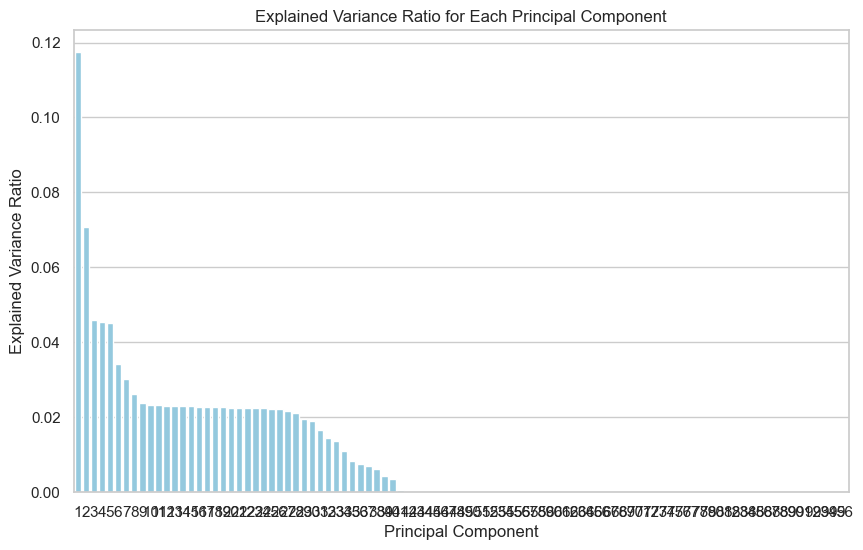

Number of components to retain: 32
       Bearer Id    Start ms      End ms  Dur. (ms)          IMSI  \
75  7.349883e+18  601.000000  766.000000   278864.0  2.082015e+14   
79  1.311448e+19  450.000000  201.000000   276284.0  2.082015e+14   
80  1.311448e+19  407.000000  444.000000   266882.0  2.082021e+14   
81  7.349883e+18  524.751521  523.918927   275891.0  2.082010e+14   
85  1.304243e+19  341.000000  631.000000   261328.0  2.082010e+14   

    MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
75   3.361644e+10  3.543841e+13        51.000000       176.837163   
79   3.377802e+10  8.692440e+13       213.056424       176.837163   
80   3.366132e+10  3.530731e+13       213.056424       176.837163   
81   3.366745e+10  8.645970e+13       213.056424       176.837163   
85   3.367588e+10  8.672400e+13        76.000000       176.837163   

    Avg Bearer TP DL (kbps)  ...      PC23      PC24      PC25      PC26  \
75             21660.940053  ... -0.903076  1.430047 -0.216

In [60]:
# Select relevant columns for PCA
pca_data = filtered_numeric_df

columns_to_exclude = ['Be']
for column in pca_data.columns:
    if column not in columns_to_exclude:
        pca_data[column].fillna(pca_data[column].mean(), inplace=True)

# Standardize the data
scaler = StandardScaler()
pca_data_standardized = scaler.fit_transform(pca_data)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(pca_data_standardized)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, pca.n_components_ + 1)), y=pca.explained_variance_ratio_, color='skyblue')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Choose the number of components based on the explained variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
num_components = len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.95])
print(f"Number of components to retain: {num_components}")

# Retrain PCA with the selected number of components
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(pca_data_standardized)

# Create a DataFrame with the principal components
pc_columns = [f'PC{i}' for i in range(1, num_components + 1)]
pc_df = pd.DataFrame(data=pca_result, columns=pc_columns)

# Concatenate the principal components DataFrame with the original data
result_df = pd.concat([filtered_numeric_df, pc_df], axis=1)

# Display the results
print(result_df.head())